In [1]:
import os
os.chdir('..')

In [76]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples
from src.data import extract, transform, load
from src.models import embedding as embedding_model, utils as model_utils
from src.models import clustering
from src.visualization import data_plots

from src.tools.startup import settings

import tensorflow as tf
from tensorboard.plugins import projector

import pandas as pd
pd.options.mode.chained_assignment = None

In [3]:
os.environ['SENTENCE_TRANSFORMERS_HOME'] = './.cache'

## Constants

In [4]:
# Folders
processed_folder = os.path.join(settings['volumes']['processed'])
interim_folder = os.path.join(settings['volumes']['interim'])
raw_folder = os.path.join(settings['volumes']['raw'])

# Multilingual
multilingual = embedding_model.EmbeddingType.multilingual.value
muse_languages = settings['embeddings']['muse']['languages']

# Separate languages
separate_languages = embedding_model.EmbeddingType.separate_languages.value
spacy_languages = settings['embeddings']['spacy']['languages']

# Multilingual tranformer
multilingual_transformer = embedding_model.EmbeddingType.multilingual_transformer.value

# TF-IDF method
tfidf_by_language = embedding_model.TfidfMethod.by_language.value
tfidf_cross_language = embedding_model.TfidfMethod.cross_language.value

max_clusters = 10
random_seed = 90

experiments_file_path = os.path.join(interim_folder, 'experiments.csv')

## Parameters

In [88]:
filenames = [
    os.path.join(processed_folder, 'all_words_bloc1_processed.json'),
    os.path.join(processed_folder, 'all_words_bloc2_processed.json'),
]

no_processed_filenames = [
    os.path.join(raw_folder, 'all_words_bloc1.json'),
    os.path.join(raw_folder, 'all_words_bloc2.json'),
    os.path.join(raw_folder, 'all_words_bloc2_Revista.json'),
    os.path.join(raw_folder, 'all_words_bloc2_Revista nova.json'),
]

folders = [
    os.path.join(processed_folder, 'bloc1_processed'),
    os.path.join(processed_folder, 'bloc2_processed')
]

no_processed_folders = [
    os.path.join(raw_folder, 'bloc1'),
    os.path.join(raw_folder, 'bloc2')
]

stats_bloc1 = os.path.join(processed_folder, 'results_bloc1_processed.csv')
stats_bloc2 = os.path.join(processed_folder, 'results_bloc2_processed.csv')

## Extract

#### Extract non-processed files

In [6]:
no_pro_multilingual_corpus_df = extract.read_processed_ocrs(
    muse_languages, no_processed_filenames)
no_pro_sep_lang_corpus_df = extract.read_processed_ocrs(
    spacy_languages, no_processed_filenames)
no_pro_multilingual_transformer_df = extract.read_processed_ocr_full_text(
   no_processed_folders)

In [7]:
no_pro_multilingual_corpus_df.fillna('', inplace=True)
no_pro_sep_lang_corpus_df.fillna('', inplace=True)
no_pro_multilingual_transformer_df.fillna('', inplace=True)

#### Extract processed files

In [8]:
multilingual_corpus_df = extract.read_processed_ocrs(
    muse_languages, filenames)
sep_lang_corpus_df = extract.read_processed_ocrs(
    spacy_languages, filenames)
multilingual_transformer_df = extract.read_processed_ocr_full_text(folders)

In [9]:
multilingual_corpus_df.fillna('', inplace=True)
sep_lang_corpus_df.fillna('', inplace=True)
multilingual_transformer_df.fillna('', inplace=True)

#### Stats files

In [199]:
stats_bloc1_df = pd.read_csv(stats_bloc1)
stats_bloc2_df = pd.read_csv(stats_bloc2)

## Transform

### Clean stats files

In [200]:
stats_bloc1_df['doc_id'] = \
    stats_bloc1_df.revista + '_' + stats_bloc1_df.publicacio.str[:-4]

In [201]:
stats_bloc2_df['doc_id'] = \
    stats_bloc2_df.revista + '_' + stats_bloc2_df.publicacio.str[:-4]

In [202]:
stats_df = pd.concat([stats_bloc1_df, stats_bloc2_df], ignore_index=True)
stats_df = stats_df[['doc_id', 'total_existing']]

### Experiments

In [10]:
results = []

if not os.path.exists(experiments_file_path):
    # Multilingual and Seperate languagues.
    embedding_types = [
        multilingual, 
        separate_languages, 
    ]
    
    search_space = [
        {'weight_by_tfidf': False, 'clean_texts': False},
        {'weight_by_tfidf': False, 'clean_texts': True},
        {'weight_by_tfidf': True, 'tfidf_method': tfidf_by_language, 'clean_texts': True}, 
        {'weight_by_tfidf': True, 'tfidf_method': tfidf_by_language, 'clean_texts': False},
        {'weight_by_tfidf': True, 'tfidf_method': tfidf_cross_language, 'clean_texts': True},
        {'weight_by_tfidf': True, 'tfidf_method': tfidf_cross_language, 'clean_texts': False},   
    ]
    
    for embedding_type in embedding_types:
        print(f'embedding_type {embedding_type}')
        for params in search_space:
            # Prepare data.
            if embedding_type == multilingual:
                corpus_df = multilingual_corpus_df.copy(deep=True)
            else:
                corpus_df = sep_lang_corpus_df.copy(deep=True)
        
            # Copy parameter experiments
            iter_params = copy.deepcopy(params)
            iter_params['embedding_type'] = embedding_type
            print(f'Iter params {iter_params}')
        
            # Compute embeddings.
            try:
                em = embedding_model.Embedder(
                    corpus_df, 
                    text_type='processed', 
                    **iter_params)
                
                em.compute_doc_embeddings()
            
                # Prepare data for computing clustering metrics
                sample = list(em.embeddings.items())
                sample_doc_ids = np.array([x[0] for x in sample])
                sample_embeddings = np.array([x[1] for x in sample])
            
                # Clustering
                clusters, labels, scores, optimal_k = clustering.perform_clustering(
                    sample_embeddings, max_clusters=max_clusters, 
                    random_state=random_seed)
            
                iter_params['optimal_k'] = optimal_k
                            
                # Save metrics
                results.append({**iter_params, **scores[optimal_k]})
    
            except Exception as e:
                print(f'Error {e}')

    # Multilingual Transformer
    params = {
        'weight_by_tfidf': None,
        'tfidf_method': None, 
        'clean_texts': False,
        'embedding_type': multilingual_transformer,
    }
    em = embedding_model.Embedder(
        multilingual_transformer_df,
        text_type='processed',
        **params)
    em.compute_doc_embeddings()
    
    # Prepare data for computing clustering metrics
    sample = list(em.embeddings.items())
    sample_doc_ids = np.array([x[0] for x in sample])
    sample_embeddings = np.array([x[1] for x in sample])

    # Clustering
    clusters, labels, scores, optimal_k = clustering.perform_clustering(
        sample_embeddings, max_clusters=max_clusters, 
        random_state=random_seed)
    
    params['optimal_k'] = optimal_k
        
    # Save metrics.
    results.append({**params, **scores[optimal_k]})
    results_df = pd.DataFrame(results) \
        .sort_values('Silhouette Score', ascending=False)

    results_df.to_csv(experiments_file_path, index=False)

else:
    results_df = pd.read_csv(experiments_file_path)

In [11]:
results_df

,weight_by_tfidf,clean_texts,embedding_type,optimal_k,Silhouette Score,Davis-Bouldin Score,Calinski and Harabasz Score,tfidf_method
0,False,False,separate_languages,2,0.735112,0.461201,2888.403413,NaN
1,False,True,separate_languages,2,0.734729,0.462114,2879.324498,NaN
2,NaN,False,multilingual_transformer,2,0.493351,0.917318,665.729498,NaN
3,True,False,multilingual,2,0.362282,0.876426,334.017175,by_language
4,True,False,multilingual,2,0.357429,0.879525,327.462042,cross_language
5,False,True,multilingual,6,0.334088,1.016931,200.261621,NaN
6,False,False,multilingual,4,0.319144,1.330056,248.596758,NaN
7,True,True,multilingual,2,0.285891,1.041213,229.571891,by_language
8,True,True,multilingual,2,0.277977,1.050516,222.202778,cross_language


### Compare results

In [12]:
best_params_df = results_df \
    .sort_values('Silhouette Score', ascending=False) \
    .groupby('embedding_type') \
    .first()

best_params_df

,weight_by_tfidf,clean_texts,optimal_k,Silhouette Score,Davis-Bouldin Score,Calinski and Harabasz Score,tfidf_method
embedding_type,,,,,,,
multilingual,True,False,2,0.362282,0.876426,334.017175,by_language
multilingual_transformer,None,False,2,0.493351,0.917318,665.729498,None
separate_languages,False,False,2,0.735112,0.461201,2888.403413,None


### Run each model with the best combination of hyperparameters

In [13]:
embedder_params = [
    'weight_by_tfidf',
    'clean_texts',
    'tfidf_method'
]

results = []
for embedding_type, row in best_params_df.iterrows():
    
    # Get the best configurations
    print(f'Embedding type {embedding_type}')
    iter_params = row[embedder_params].to_dict()
    iter_params['embedding_type'] = embedding_type

    print(iter_params)
    # Prepare data.
    if embedding_type == multilingual:
        non_processed_corpus_df = no_pro_multilingual_corpus_df \
            .copy(deep=True)
        corpus_df = multilingual_corpus_df.copy(deep=True)
    elif embedding_type == separate_languages:
        non_processed_corpus_df = no_pro_sep_lang_corpus_df \
            .copy(deep=True)
        corpus_df = sep_lang_corpus_df.copy(deep=True)
    else:
        non_processed_corpus_df = no_pro_multilingual_transformer_df.copy(deep=True)
        corpus_df = multilingual_transformer_df.copy(deep=True)


    # Run with unprocessed text.
    em = embedding_model.Embedder(
        non_processed_corpus_df, 
        **iter_params)
    
    em.compute_doc_embeddings()

    # Prepare data for computing clustering metrics
    sample = list(em.embeddings.items())
    sample_doc_ids = np.array([x[0] for x in sample])
    sample_embeddings = np.array([x[1] for x in sample])

    clusters, labels, non_pro_scores, non_pro_optimal_k = clustering.perform_clustering(
        sample_embeddings, max_clusters=max_clusters, 
        random_state=random_seed)

    # Run with processed text.
    em = embedding_model.Embedder(
        corpus_df, 
        text_type='processed', 
        **iter_params)
    
    em.compute_doc_embeddings()

    # Prepare data for computing clustering metrics
    sample = list(em.embeddings.items())
    sample_doc_ids = np.array([x[0] for x in sample])
    sample_embeddings = np.array([x[1] for x in sample])

    clusters, labels, scores, optimal_k = clustering.perform_clustering(
        sample_embeddings, max_clusters=max_clusters, 
        random_state=random_seed)

    results.append({
        'embedding_type': embedding_type,
        'non_pro_scores': non_pro_scores,
        'non_pro_optimal_k': non_pro_optimal_k,
        'scores': scores,
        'optimal_k': optimal_k,
    })

Embedding type multilingual
{'weight_by_tfidf': True, 'clean_texts': False, 'tfidf_method': 'by_language', 'embedding_type': 'multilingual'}
2023-11-22 15:39:58 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:39:58 - INFO - embedding.py - __init__: Running embedding type 'multilingual'...
2023-11-22 15:41:00 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'ca'
2023-11-22 15:41:00 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:41:03 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 15:41:03 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'es'
2023-11-22 15:41:03 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:41:05 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 15:41:05 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'fr'
2023-11-22 15:41:05 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:41:05 -

Computing embeddings: 946it [05:17,  2.98it/s]

2023-11-22 15:46:24 - INFO - embedding.py - compute_doc_embeddings: Done



Fitting clustering model: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, k=10]

2023-11-22 15:46:25 - INFO - clustering.py - perform_clustering: Optimal k is 7
2023-11-22 15:46:25 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.2457781879405483, 'Davis-Bouldin Score': 1.8464728541825008, 'Calinski and Harabasz Score': 140.68231251186592}


2023-11-22 15:46:25 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:46:25 - INFO - embedding.py - __init__: Running embedding type 'multilingual'...
2023-11-22 15:46:54 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'ca'
2023-11-22 15:46:54 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:47:00 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 15:47:00 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'es'
2023-11-22 15:47:00 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:47:01 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 15:47:01 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'fr'
2023-11-22 15:47:01 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 15:47:02 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 15:47:02 - INFO - embedding.py - compute_word_relevances: Running by_language for langu

Computing embeddings: 945it [04:53,  3.22it/s]

2023-11-22 15:51:56 - INFO - embedding.py - compute_doc_embeddings: Done



Fitting clustering model: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, k=10]

2023-11-22 15:51:57 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-22 15:51:57 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.36228216439662214, 'Davis-Bouldin Score': 0.8764257189611416, 'Calinski and Harabasz Score': 334.0171750184395}


Embedding type multilingual_transformer
{'weight_by_tfidf': None, 'clean_texts': False, 'tfidf_method': None, 'embedding_type': 'multilingual_transformer'}
2023-11-22 15:51:57 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:51:57 - INFO - embedding.py - __init__: Running embedding type 'multilingual_transformer'...
2023-11-22 15:51:58 - INFO - embedding.py - _compute_multilingual_transformer: Generating chunks from text...
2023-11-22 15:51:58 - INFO - embedding.py - _compute_multilingual_transformer: Done.


No sentence-transformers model found with name ./.cache/bert-base-multilingual-cased. Creating a new one with MEAN pooling.
Computing embeddings: 946it [00:01, 489.42it/s]
Fitting clustering model: 100%|██████████| 9/9 [00:00<00:00, 15.36it/s, k=10]

2023-11-22 15:52:07 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-22 15:52:07 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.4577221, 'Davis-Bouldin Score': 0.9638237184206663, 'Calinski and Harabasz Score': 529.3312329929277}
2023-11-22 15:52:07 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:52:07 - INFO - embedding.py - __init__: Running embedding type 'multilingual_transformer'...
2023-11-22 15:52:07 - INFO - embedding.py - _compute_multilingual_transformer: Generating chunks from text...


2023-11-22 15:52:07 - INFO - embedding.py - _compute_multilingual_transformer: Done.


No sentence-transformers model found with name ./.cache/bert-base-multilingual-cased. Creating a new one with MEAN pooling.
Computing embeddings: 945it [00:03, 262.19it/s]
Fitting clustering model: 100%|██████████| 9/9 [00:00<00:00, 16.74it/s, k=10]

2023-11-22 15:52:14 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-22 15:52:14 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.49335125, 'Davis-Bouldin Score': 0.9173178079236961, 'Calinski and Harabasz Score': 665.7294980419189}


Embedding type separate_languages
{'weight_by_tfidf': False, 'clean_texts': False, 'tfidf_method': None, 'embedding_type': 'separate_languages'}
2023-11-22 15:52:14 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:52:14 - INFO - embedding.py - __init__: Running embedding type 'separate_languages'...


Computing embeddings: 946it [01:24, 11.17it/s] 

2023-11-22 15:53:39 - INFO - embedding.py - compute_doc_embeddings: Done



Fitting clustering model: 100%|██████████| 9/9 [00:00<00:00, 19.53it/s, k=10]

2023-11-22 15:53:40 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-22 15:53:40 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.72545433, 'Davis-Bouldin Score': 0.47665515833660715, 'Calinski and Harabasz Score': 2673.4486950046376}
2023-11-22 15:53:40 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 15:53:40 - INFO - embedding.py - __init__: Running embedding type 'separate_languages'...



Computing embeddings: 945it [05:03,  3.12it/s]

2023-11-22 15:58:44 - INFO - embedding.py - compute_doc_embeddings: Done



Fitting clustering model: 100%|██████████| 9/9 [00:00<00:00, 20.19it/s, k=10]

2023-11-22 15:58:44 - INFO - clustering.py - perform_clustering: Optimal k is 2
2023-11-22 15:58:44 - INFO - clustering.py - perform_clustering: Scores of optimal k:
{'Silhouette Score': 0.7351116661006386, 'Davis-Bouldin Score': 0.4612007507770536, 'Calinski and Harabasz Score': 2888.403412993921}


### Compare the Silhouette score of the original data vs the Silhouette score of processed data

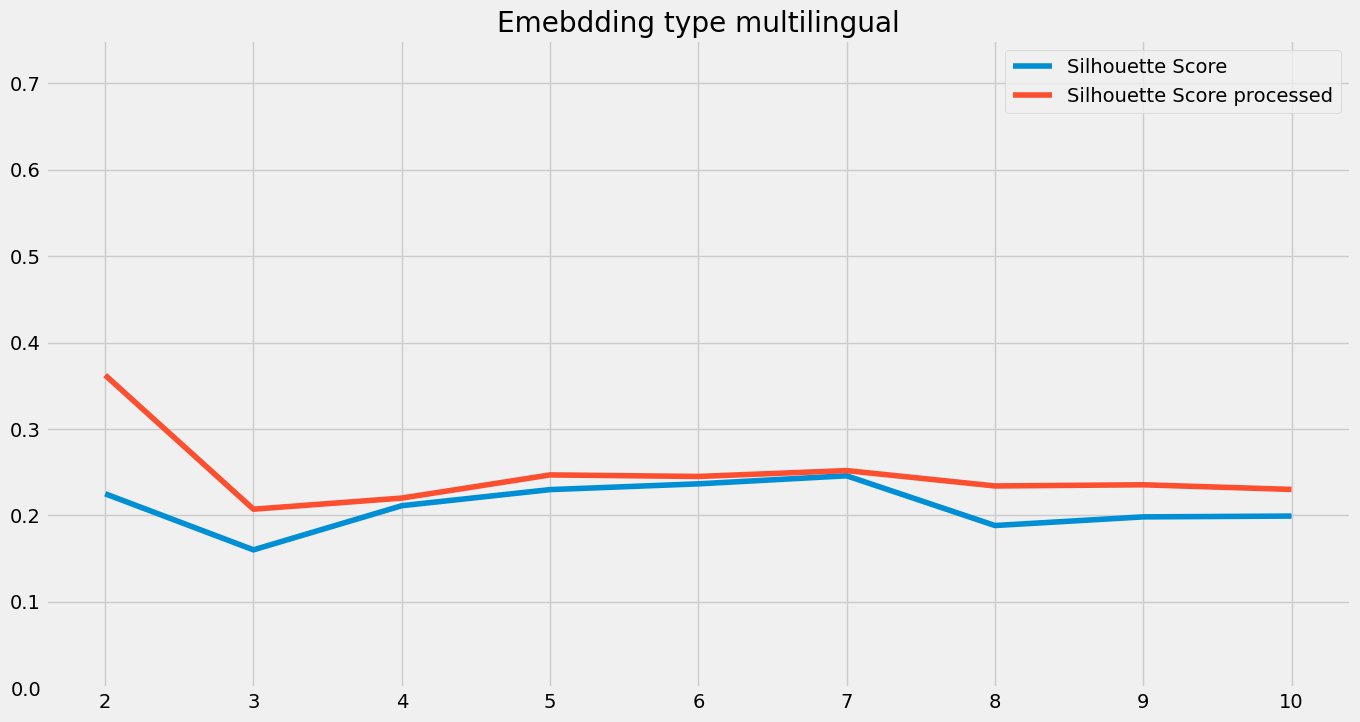

In [14]:
non_pro_df = pd.DataFrame(results[0]['non_pro_scores']).transpose()
non_pro_df['processed'] = False

pro_df = pd.DataFrame(results[0]['scores']).transpose()
pro_df['processed'] = True
pro_df = pro_df.add_suffix(' processed')

df = pd.concat([non_pro_df, pro_df])

_ = df.plot(kind='line', y= ['Silhouette Score', 'Silhouette Score processed'], 
            figsize=(15, 8), title='Emebdding type multilingual', ylim=(0, .75))

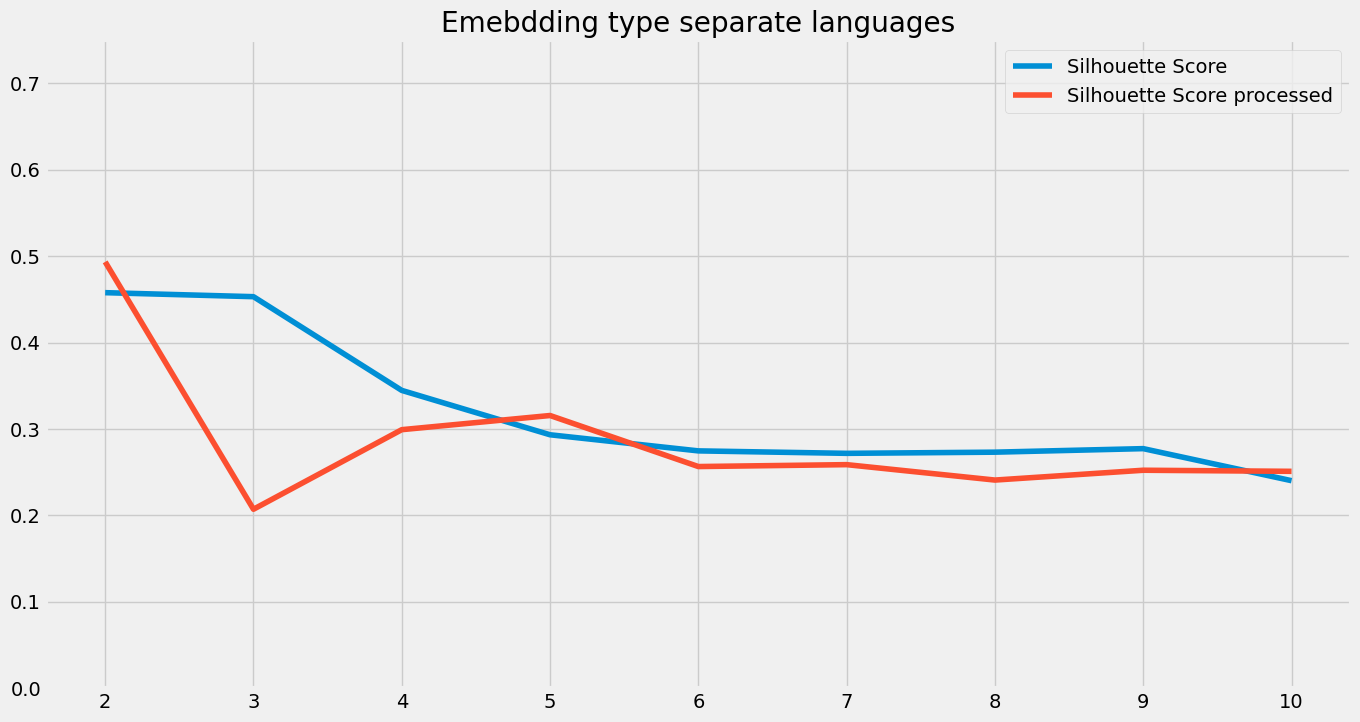

In [15]:
non_pro_df = pd.DataFrame(results[1]['non_pro_scores']).transpose()
non_pro_df['processed'] = False

pro_df = pd.DataFrame(results[1]['scores']).transpose()
pro_df['processed'] = True
pro_df = pro_df.add_suffix(' processed')

df = pd.concat([non_pro_df, pro_df])

_ = df.plot(kind='line', y= ['Silhouette Score', 'Silhouette Score processed'], figsize=(15, 8),
            title='Emebdding type separate languages',ylim=(0, .75))

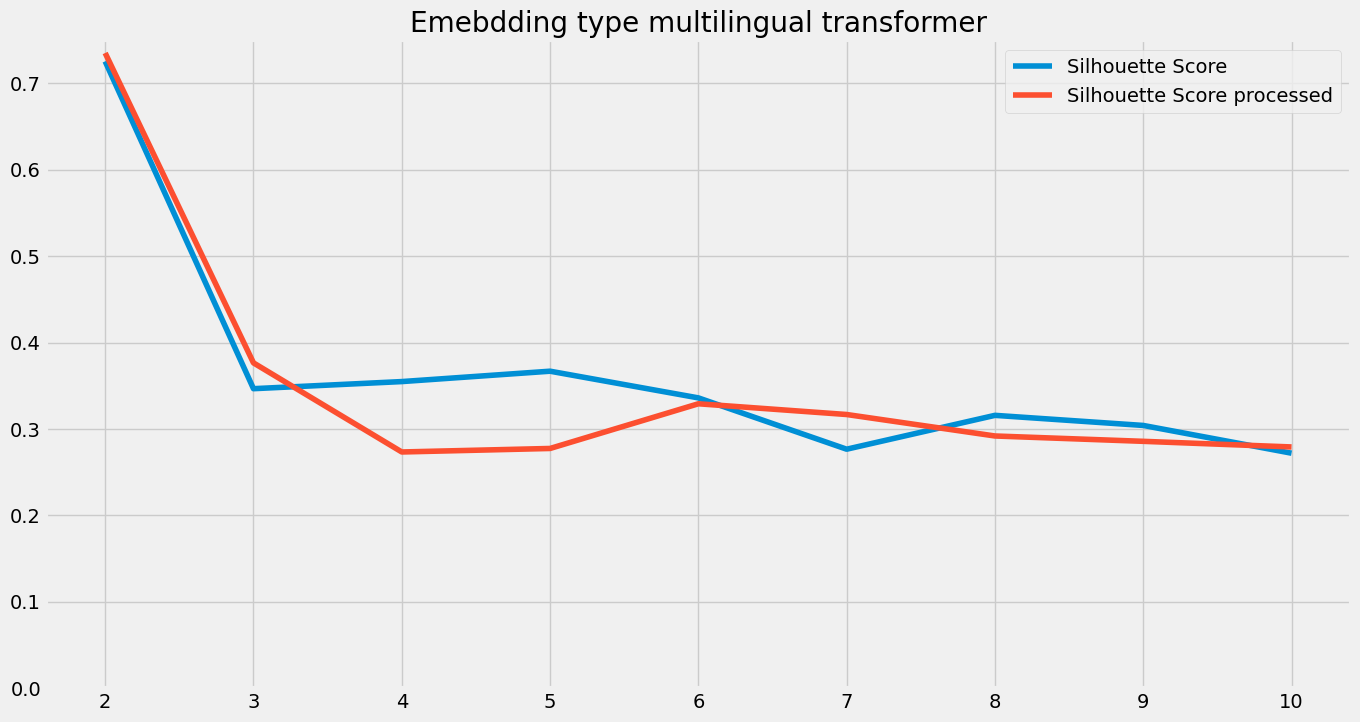

In [16]:
non_pro_df = pd.DataFrame(results[2]['non_pro_scores']).transpose()
non_pro_df['processed'] = False

pro_df = pd.DataFrame(results[2]['scores']).transpose()
pro_df['processed'] = True
pro_df = pro_df.add_suffix(' processed')

df = pd.concat([non_pro_df, pro_df])

_ = df.plot(kind='line', y= ['Silhouette Score', 'Silhouette Score processed'], figsize=(15, 8),
            title='Emebdding type multilingual transformer', ylim=(0, .75))

### Create a plot with the aim to compare the % recongized words and the Silhouette score for each sample

#### Multilingual transformer

In [25]:
corpus_df = multilingual_transformer_df.copy(deep=True)

In [26]:
em_transformer = embedding_model.Embedder(
    corpus_df,
    embedding_type=multilingual_transformer,
    clean_texts=False,
    text_type='processed',
)
    
em_transformer.compute_doc_embeddings()

2023-11-22 16:08:04 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 16:08:04 - INFO - embedding.py - __init__: Running embedding type 'multilingual_transformer'...
2023-11-22 16:08:04 - INFO - embedding.py - _compute_multilingual_transformer: Generating chunks from text...
2023-11-22 16:08:04 - INFO - embedding.py - _compute_multilingual_transformer: Done.


No sentence-transformers model found with name ./.cache/bert-base-multilingual-cased. Creating a new one with MEAN pooling.
Computing embeddings: 945it [00:00, 3420.83it/s]


#### Prepare data for computing clustering metrics

In [203]:
sample = list(em_transformer.embeddings.items())
sample_doc_ids = np.array([x[0] for x in sample])
sample_embeddings = np.array([x[1] for x in sample])

#### Clustering

In [204]:
clustering_model = clustering.create_model('KMeans', n_clusters=3)
labels = clustering_model.fit_predict(sample_embeddings)

In [205]:
doc_ids_df = pd.DataFrame(sample_doc_ids, columns=['doc_id'])
doc_ids_df['score_multilingual_transformer'] = \
    silhouette_samples(sample_embeddings, labels)

In [206]:
stats_df = pd.merge(stats_df, doc_ids_df, on='doc_id')

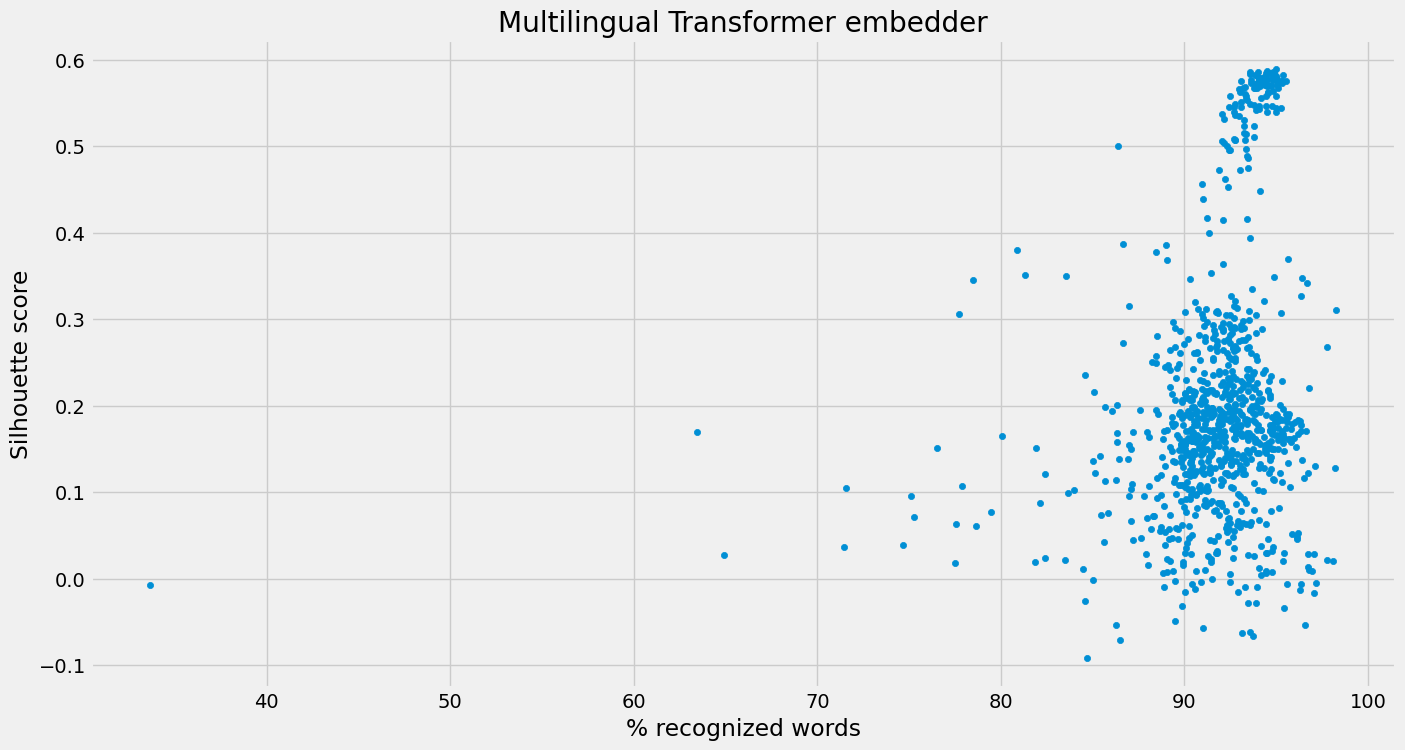

In [207]:
_ = stats_df.plot(
    kind='scatter', x='total_existing', y='score_multilingual_transformer', figsize=(15, 8), 
    ylabel='Silhouette score', xlabel='% recognized words', title='Multilingual Transformer embedder')

####  Multilingual

In [184]:
corpus_df = multilingual_corpus_df.copy(deep=True)

In [186]:
# Run with unprocessed text.
em_multi = embedding_model.Embedder(
    corpus_df, 
    embedding_type=multilingual, 
    weight_by_tfidf=True, 
    clean_texts=False, 
    tfidf_method='by_language')

em_multi.compute_doc_embeddings()

2023-11-22 17:25:09 - INFO - embedding.py - __init__: Device: cpu
2023-11-22 17:25:09 - INFO - embedding.py - __init__: Running embedding type 'multilingual'...
2023-11-22 17:26:21 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'ca'
2023-11-22 17:26:21 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 17:26:27 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 17:26:27 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'es'
2023-11-22 17:26:27 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 17:26:28 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 17:26:28 - INFO - embedding.py - compute_word_relevances: Running by_language for language 'fr'
2023-11-22 17:26:28 - INFO - embedding.py - _apply_tfidf: Running TF-IDF...
2023-11-22 17:26:29 - INFO - embedding.py - _apply_tfidf: Done.
2023-11-22 17:26:29 - INFO - embedding.py - compute_word_relevances: Running by_language for langu

Computing embeddings: 945it [04:39,  3.39it/s]

2023-11-22 17:31:08 - INFO - embedding.py - compute_doc_embeddings: Done


#### Prepare data for computing clustering metrics

In [208]:
sample = list(em_multi.embeddings.items())
sample_doc_ids = np.array([x[0] for x in sample])
sample_embeddings = np.array([x[1] for x in sample])

In [209]:
sample_embeddings.shape

(945, 300)

#### Clustering

In [210]:
clustering_model = clustering.create_model('KMeans', n_clusters=7)
labels = clustering_model.fit_predict(sample_embeddings)

In [211]:
doc_ids_df = pd.DataFrame(sample_doc_ids, columns=['doc_id'])
doc_ids_df['score_multilingual'] = silhouette_samples(sample_embeddings, labels)

In [213]:
stats_df = pd.merge(stats_df, doc_ids_df, on='doc_id')

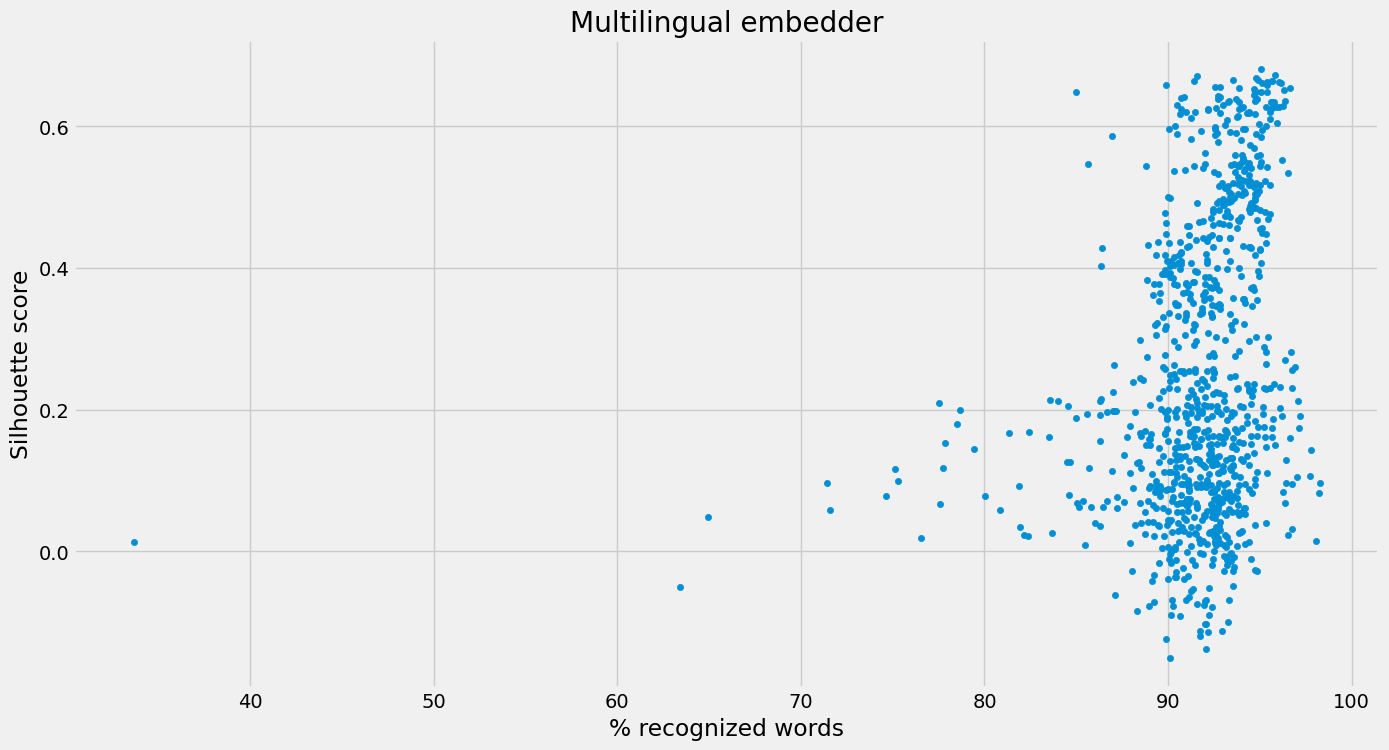

In [216]:
_ = stats_df.plot(
    kind='scatter', x='total_existing', y='score_multilingual', figsize=(15, 8), 
    ylabel='Silhouette score', xlabel='% recognized words', title='Multilingual embedder')

## Load

In [218]:
stats_df.to_csv('stats.csv', index=False)